In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import sys

sys.path.append("/home/dchen/BA_CH_EN/")


import os

os.environ[
    "CUDA_VISIBLE_DEVICES"
] = "-1"  # this line tells TensorFlow not to use any GPU
# Basics
import tensorflow as tf
import xarray as xr
import pandas as pd

# Helpful
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt

# My Methods
from src.utils.CRPS import *  # CRPS metrics
from src.utils.data_split import *  # Splitting data into X and y
from src.utils.drn_make_X_array import *  # Import make train array functions (make_X_array)
from src.models.EMOS import *  # EMOS implementation
from src.models.DRN.DRN_model import *  # DRN implementation
from src.models.EMOS_global.EMOS_global_load_score import *  # Load EMOS_global_scores
from src.models.EMOS_local.EMOS_local_load_score import *  # Load EMOS_global_scores
from src.models.DRN.DRN_load_score import *  # Load DRN_scores
from src.models.EMOS_global.EMOS_global_load_model import *  # Load EMOS_global_models
from src.models.DRN.DRN_load_score_dummy_10 import *  # Load DRN_scores_10
import data.raw.load_data_raw as ldr  # Load raw data
import data.processed.load_data_processed as ldp  # Load processed data normed
import data.processed.load_data_processed_denormed as ldpd  # Load processed data denormed
from src.models.CRPS_baseline.CRPS_load import *  # Load CRPS scores
from src.models.U_net.unet import Unet
from src.models.U_net.u_net_tests_params import *
from src.models.U_net.unet import *
from src.models.U_net.u_net_predict_evaluate import *

<IPython.core.display.Javascript object>

### 0. Set Up

In [3]:
lead_time = 0
var_num = 5

land_sea_mask_dummy = np.load(
    "/Data/Delong_BA_Data/land_sea_mask_dummy/land_sea_mask_dummy.npy"
)
land_sea_mask_dummy = pad_land_sea_mask(land_sea_mask_dummy)
land_sea_mask_dummy = np.repeat(land_sea_mask_dummy[np.newaxis, ...], 357, axis=0)

# load data
test_var_mean = []
test_var_std = []
test_var_y = []
for var in range(6):
    (
        padded_test_data_mean,
        padded_test_data_std,
        padded_test_data_y,
    ) = u_net_load_test_data(var, lead_time)
    test_var_mean.append(padded_test_data_mean)
    test_var_std.append(padded_test_data_std)
    test_var_y.append(padded_test_data_y)

# Then, pack all of your input data into a list
test_inputs = test_var_mean + test_var_std + [land_sea_mask_dummy]

test_target = test_var_y[var_num]

<IPython.core.display.Javascript object>

In [4]:
def plot_losses(csv_filepath, starting_epoch=0, ending_epoch=1000000000):
    # Load the csv file into a pandas DataFrame
    data = pd.read_csv(csv_filepath).iloc[starting_epoch:ending_epoch]

    # Create a new figure
    plt.figure(figsize=(10, 5))

    # Plot the training loss
    plt.plot(data["epoch"], data["loss"], label="Train Loss")

    # Plot the validation loss
    plt.plot(data["epoch"], data["val_loss"], label="Validation Loss")

    # Set the labels for the x and y axes
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    # Set the title for the plot
    plt.title("Training and Validation Loss")

    # Enable the legend
    plt.legend()

    # Display the plot
    plt.show()
    return data

<IPython.core.display.Javascript object>

In [5]:
def test_best_model(path, var_num, lead_time):

    model = tf.keras.models.load_model(
        path,
        custom_objects={
            "crps_cost_function_U": crps_cost_function_U,
            "crps_cost_function_trunc_U": crps_cost_function_trunc_U,
            "CustomSchedule": CustomSchedule,
        },
    )
    # load land_sea_mask
    land_sea_mask_dummy = np.load(
        "/Data/Delong_BA_Data/land_sea_mask_dummy/land_sea_mask_dummy.npy"
    )
    land_sea_mask_dummy = pad_land_sea_mask(land_sea_mask_dummy)
    land_sea_mask_dummy = np.repeat(land_sea_mask_dummy[np.newaxis, ...], 357, axis=0)
    # load data
    test_var_mean = []
    test_var_std = []
    test_var_y = []
    for var in range(6):
        (
            padded_test_data_mean,
            padded_test_data_std,
            padded_test_data_y,
        ) = u_net_load_test_data(var, lead_time)
        test_var_mean.append(padded_test_data_mean)
        test_var_std.append(padded_test_data_std)
        test_var_y.append(padded_test_data_y)

    # Then, pack all of your input data into a list
    test_inputs = test_var_mean + test_var_std + [land_sea_mask_dummy]

    test_target = test_var_y[var_num]
    test_target_unpad = unpad_images_y(test_target)

    preds = model.predict(test_inputs, verbose=1)
    predictions_unpad = unpad_images(preds)
    if var_num in [5]:
        crps = crps_trunc
    else:
        crps = crps_normal

    scores = crps(
        mu=predictions_unpad[:, :, :, 0].flatten(),
        sigma=predictions_unpad[:, :, :, 1].flatten(),
        y=test_target_unpad.flatten(),
    )
    scores = scores.reshape((357, 120, 130)).mean(axis=0)
    return predictions_unpad, scores

<IPython.core.display.Javascript object>

In [6]:
def train_best_model(path, var_num, lead_time):

    model = tf.keras.models.load_model(
        path,
        custom_objects={
            "crps_cost_function_U": crps_cost_function_U,
            "crps_cost_function_trunc_U": crps_cost_function_trunc_U,
            "CustomSchedule": CustomSchedule,
        },
    )
    # load land_sea_mask
    land_sea_mask_dummy = np.load(
        "/Data/Delong_BA_Data/land_sea_mask_dummy/land_sea_mask_dummy.npy"
    )
    land_sea_mask_dummy = pad_land_sea_mask(land_sea_mask_dummy)
    land_sea_mask_dummy = np.repeat(land_sea_mask_dummy[np.newaxis, ...], 1429, axis=0)
    # load data
    train_var_mean = []
    train_var_std = []
    train_var_y = []
    for var in range(6):
        (
            padded_train_data_mean,
            padded_train_data_std,
            padded_train_data_y,
        ) = u_net_load_train_data(var, lead_time)
        train_var_mean.append(padded_train_data_mean)
        train_var_std.append(padded_train_data_std)
        train_var_y.append(padded_train_data_y)

    # Then, pack all of your input data into a list
    train_inputs = train_var_mean + train_var_std + [land_sea_mask_dummy]

    train_target = train_var_y[var_num]
    train_target_unpad = unpad_images_y(train_target)

    preds = model.predict(train_inputs, verbose=1)
    predictions_unpad = unpad_images(preds)
    if var_num in [5]:
        crps = crps_trunc
    else:
        crps = crps_normal

    scores = crps(
        mu=predictions_unpad[:, :, :, 0].flatten(),
        sigma=predictions_unpad[:, :, :, 1].flatten(),
        y=train_target_unpad.flatten(),
    )
    scores = scores.reshape((1429, 120, 130)).mean(axis=0)
    return predictions_unpad, scores


<IPython.core.display.Javascript object>

### Run 1

### Run 2

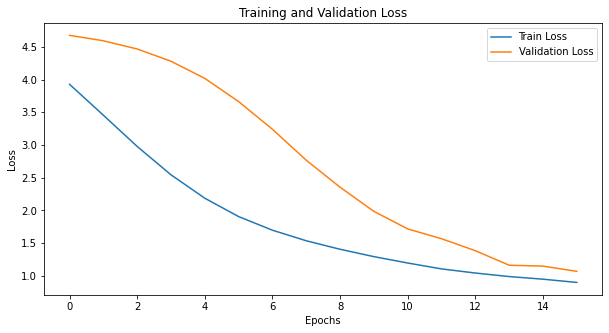

<IPython.core.display.Javascript object>

In [11]:
df_run_1_0 = plot_losses(
    "/Data/Delong_BA_Data/models/U_net/csv_log/_training_log_var_5_lead_0_lr_1e-05_ep_3000_bs_32_filters24.csv"
)

In [12]:
df_run_1_0

,epoch,loss,val_loss
0,0,3.928156,4.677352
1,1,3.454916,4.594439
2,2,2.977125,4.468586
3,3,2.543129,4.281043
4,4,2.184974,4.018570
5,5,1.904050,3.663578
6,6,1.695647,3.239370
7,7,1.533859,2.766093
8,8,1.403946,2.352904
9,9,1.291102,1.983791


<IPython.core.display.Javascript object>

In [13]:
test_preds, test_scores = test_best_model(
    "/Data/Delong_BA_Data/models/U_net/models/_unet_model_var_5_lead_0_lr_1e-05_ep_3000_bs_32_filters24.h5",
    5,
    0,
)

print(f"Number of Nan Values: {np.isnan(test_scores).sum()}")
print(f"Number of inf Values: {np.isinf(test_scores).sum()}")
testing = test_scores[~np.isnan(test_scores)]
testing = testing[~np.isinf(testing)]
testing.mean()

12/12 [==============================] - 23s 2s/step
Number of Nan Values: 0
Number of inf Values: 0


0.85276455

<IPython.core.display.Javascript object>

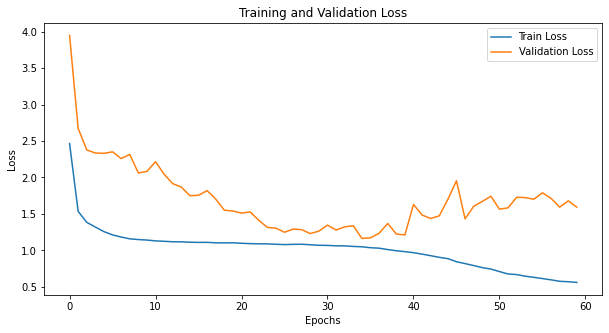

<IPython.core.display.Javascript object>

In [83]:
df_run_1_15 = plot_losses(
    "/Data/Delong_BA_Data/models/U_net/csv_log/_training_log_var_5_lead_15_lr_1e-05_ep_3000_bs_32_filters24.csv"
)

In [84]:
df_run_1_15

,epoch,loss,val_loss
0,0,2.466026,3.950325
1,1,1.534103,2.675113
2,2,1.383894,2.377306
3,3,1.319317,2.335824
4,4,1.256530,2.330908
5,5,1.211649,2.351944
6,6,1.182606,2.259700
7,7,1.157447,2.315699
8,8,1.147681,2.061188
9,9,1.140817,2.083678


<IPython.core.display.Javascript object>

In [34]:
test_preds, test_scores = test_best_model(
    "/Data/Delong_BA_Data/models/U_net/models/_unet_model_var_5_lead_15_lr_1e-05_ep_3000_bs_32_filters24.h5",
    5,
    15,
)

print(f"Number of Nan Values: {np.isnan(test_scores).sum()}")
print(f"Number of inf Values: {np.isinf(test_scores).sum()}")
testing = test_scores[~np.isnan(test_scores)]
testing = testing[~np.isinf(testing)]
testing.mean()

12/12 [==============================] - 13s 1s/step
Number of Nan Values: 0
Number of inf Values: 0


2.083296

<IPython.core.display.Javascript object>

In [ ]:
df_run_1_30 = plot_losses(
    "/Data/Delong_BA_Data/models/U_net/csv_log/_training_log_var_5_lead_30_lr_1e-05_ep_3000_bs_32_filters24.csv"
)

In [ ]:
df_run_1_30

In [ ]:
test_preds, test_scores = test_best_model(
    "/Data/Delong_BA_Data/models/U_net/models/_unet_model_var_5_lead_30_lr_1e-05_ep_3000_bs_32_filters24.h5",
    5,
    15,
)

print(f"Number of Nan Values: {np.isnan(test_scores).sum()}")
print(f"Number of inf Values: {np.isinf(test_scores).sum()}")
testing = test_scores[~np.isnan(test_scores)]
testing = testing[~np.isinf(testing)]
testing.mean()

### Test Final model

In [15]:
def final_model_run(lead_time, test=False, starting_epoch=0, ending_epoch=1000000000):
    df_run_final = plot_losses(
        f"/Data/Delong_BA_Data/models/U_net/csv_log_final/training_log_var_5_lead_{lead_time}.csv",
        starting_epoch,
        ending_epoch,
    )
    if test:
        test_preds, test_scores = test_best_model(
            f"/Data/Delong_BA_Data/models/U_net/models_final/unet_model_var_5_lead_{lead_time}.h5",
            5,
            lead_time,
        )

        print(f"Number of Nan Values: {np.isnan(test_scores).sum()}")
        print(f"Number of inf Values: {np.isinf(test_scores).sum()}")
        testing = test_scores[~np.isnan(test_scores)]
        testing = testing[~np.isinf(testing)]
        print(testing.mean())

    return df_run_final

<IPython.core.display.Javascript object>

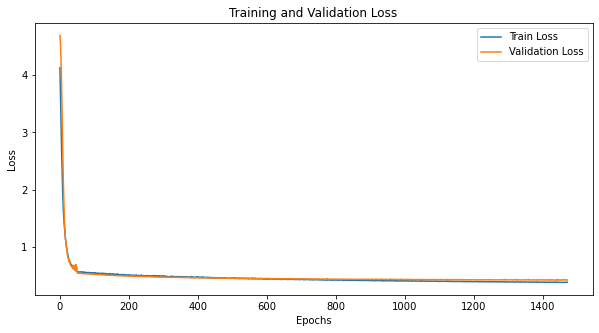

<IPython.core.display.Javascript object>

In [16]:
df_run_final = final_model_run(0, test=False)

In [17]:
df_run_final.min()

epoch       0.000000
loss        0.387507
val_loss    0.429526
dtype: float64

<IPython.core.display.Javascript object>

In [19]:
CRPS_baseline_scores_ws10[0].mean()

0.47082883

<IPython.core.display.Javascript object>

In [53]:
EMOS_loc_scores_ws10[17].mean()

1.2064466494073471

<IPython.core.display.Javascript object>

In [56]:
DRN_scores_ws10_dummy_10[17].mean()

1.1967685

<IPython.core.display.Javascript object>

In [18]:
# Baseline Scores
CRPS_baseline_scores_t2m = crps_load_lead_lat_lon("t2m")
CRPS_baseline_scores_ws10 = crps_load_lead_lat_lon("ws10")

# Global Scores:
EMOS_glob_scores_t2m = EMOS_global_load_score("t2m")
EMOS_glob_scores_ws10 = EMOS_global_load_score("ws10")

# Local Scores:
EMOS_loc_scores_t2m = EMOS_local_load_score("t2m")
EMOS_loc_scores_ws10 = EMOS_local_load_score("ws10")

# DRN 10 dummy scores:
DRN_scores_t2m_dummy_10 = DRN_load_score_dummy_10("t2m")
DRN_scores_ws10_dummy_10 = DRN_load_score_dummy_10("ws10")

<IPython.core.display.Javascript object>